In [2]:
import sys
sys.path.insert(0, '../Utilities')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import math
import time

np.random.seed(1234)

# CUDA
# if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available")
else:
    device = torch.device('cpu')
    print("Only cpu is available")


# deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # parameter
        self.depth = len(layers) - 1

        # layer order dict
        self.activation = torch.nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out


class PhysicsInformedNN:
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):

        # boundary condition
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.layers = layers
        self.nu = nu

        # deep neural network
        self.dnn = DNN(layers).to(device)

        # optimizer with same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"   # strong wolfe interpolation
        )

        self.iter = 0

    def net_u(self, x, t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        # convection diffusion equation
        f = u_t + u * u_x - self.nu * u_xx + u * u_x /500
        """
        theta = 0.748 * 0.443 / (1 + (-2.6 * u) ** 33.6) ** (1 - 1/33.6) +\
                0.252 * 0.443 / (1 + (-2.14 * u) ** 1.84) ** (1 - 1/1.84)

        da = torch.autograd.grad(
            theta, u,
            grad_outputs=torch.ones_like(theta),
            retain_graph=True,
            create_graph=True
        )[0]

        gama = - 4.2e-5 * (1.535 + 0.696 / (0.01 + theta))

        c = (0.443 - theta) * (0.443 - theta) ** (7/3) / (0.443 ** 2) * \
            (9.5 + 6 * theta - 8.5 * math.e ** -((1+2.6/math.sqrt(0.02)) * theta) ** 4) * \
            2.669e-5 * math.e ** (u / 46.97 / 298.15) * 0.02301 / ( 10 ** 3 * 298.15 * 46.97 ) - gama

        c_x = torch.autograd.grad(
            c, x,
            grad_outputs=torch.ones_like(c),
            retain_graph=True,
            create_graph=True
        )[0]

        c_xx = torch.autograd.grad(
            c_x, x,
            grad_outputs=torch.ones_like(c_x),
            retain_graph=True,
            create_graph=True
        )[0]

        gama_x = torch.autograd.grad(
            gama, x,
            grad_outputs=torch.ones_like(gama),
            retain_graph=True,
            create_graph=True
        )[0]

        f = da * u_t - c_xx + gama_x
        """
        return f

    def loss_fun(self):
        self.optimizer.zero_grad()

        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch. mean(f_pred ** 2)

        loss = loss_u + loss_f

        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' %
                (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss

    def train(self):
        self.dnn.train()

        # backward & optimizer
        self.optimizer.step(self.loss_fun)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f


if __name__ == '__main__':
    nu = 0.01/np.pi
    noise = 0.0

    N_u = 100
    N_f = 10000
    layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

    data = scipy.io.loadmat('data/burgers_shock.mat')

    t = data['t'].flatten()[:, None]
    x = data['x'].flatten()[:, None]
    Exact = np.real(data['usol']).T

    X, T = np.meshgrid(x, t)

    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = Exact.flatten()[:, None]       # X_start, U_start

    # Doman boundary
    lb = X_star.min(0)
    ub = X_star.max(0)

    xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
    uu1 = Exact[0:1, :].T
    xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))     # X = -1 boundary
    uu2 = Exact[:, 0:1]
    xx3 = np.hstack((X[:, -1:], T[:, -1:]))     # X = 1 boundary
    uu3 = Exact[:, -1:]

    X_u_train = np.vstack([xx1, xx2, xx3])
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    X_f_train = np.vstack((X_f_train, X_u_train))
    u_train = np.vstack([uu1, uu2, uu3])

    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx, :]
    u_train = u_train[idx, :]

    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

    model.train()

    u_pred, f_pred = model.predict(X_star)

    error_u = np.linalg.norm(u_star-u_pred, 2)/np.linalg.norm(u_star, 2)
    print('Error u: %e' % (error_u))

    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - U_pred)

Only cpu is available
Iter 100, Loss: 6.55086e-02, Loss_u: 4.56938e-02, Loss_f: 1.98148e-02
Iter 200, Loss: 3.23926e-02, Loss_u: 2.15583e-02, Loss_f: 1.08343e-02
Iter 300, Loss: 1.69609e-02, Loss_u: 1.10693e-02, Loss_f: 5.89164e-03
Iter 400, Loss: 7.96697e-03, Loss_u: 4.04353e-03, Loss_f: 3.92344e-03
Iter 500, Loss: 4.19968e-03, Loss_u: 1.69539e-03, Loss_f: 2.50429e-03
Iter 600, Loss: 2.52106e-03, Loss_u: 9.41533e-04, Loss_f: 1.57953e-03
Iter 700, Loss: 1.67766e-03, Loss_u: 7.62999e-04, Loss_f: 9.14659e-04
Iter 800, Loss: 1.30378e-03, Loss_u: 6.31118e-04, Loss_f: 6.72666e-04
Iter 900, Loss: 9.92096e-04, Loss_u: 3.98597e-04, Loss_f: 5.93499e-04
Iter 1000, Loss: 7.42961e-04, Loss_u: 3.12090e-04, Loss_f: 4.30871e-04
Iter 1100, Loss: 5.55039e-04, Loss_u: 2.03246e-04, Loss_f: 3.51793e-04
Iter 1200, Loss: 4.22515e-04, Loss_u: 1.32668e-04, Loss_f: 2.89847e-04
Iter 1300, Loss: 3.54963e-04, Loss_u: 1.11044e-04, Loss_f: 2.43919e-04
Iter 1400, Loss: 2.87405e-04, Loss_u: 8.03236e-05, Loss_f: 2.070

ValueError: keyword lablesize is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

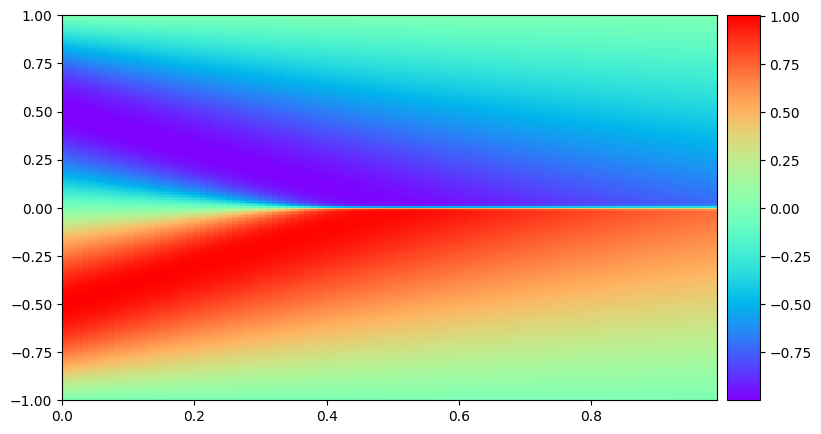

In [3]:
    # Visualization ##############################################################
    # 0 u(t, x)

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(111)

    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = fig.colorbar(h, cax=cax)
    cbar.ax.tick_params(lablesize=15)

    ax.plot(
        X_u_train[:, 1],
        X_u_train[:, 0],
        'kx', lable='Data (%d points)' % (u_train.shape([0])),
        markersize=4,
        clip_on=False,
        alpha=1.0
    )

    line = np.linspace(x.min(), x.max(), 2)[:, None]
    ax.plot(t[25]*np.ones((2, 1)), line, 'w-', linewidth=1)
    ax.plot(t[50]*np.ones((2, 1)), line, 'w-', linewidth=1)
    ax.plot(t[75]*np.ones((2, 1)), line, 'w-', linewidth=1)

    ax.set_xlabel('$t$', size=20)
    ax.set_ylabel('$x$', size=20)
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.9, -0.05),
        ncol=5,
        frameon=False,
        prop={'size': 15}
    )
    ax.set_title('$u(t, x)$', fontsize=20)
    ax.tick_params(labelsize=15)

    plt.show()

C:\Users\rinki\AppData\Local\Temp\ipykernel_13672\3967573683.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])


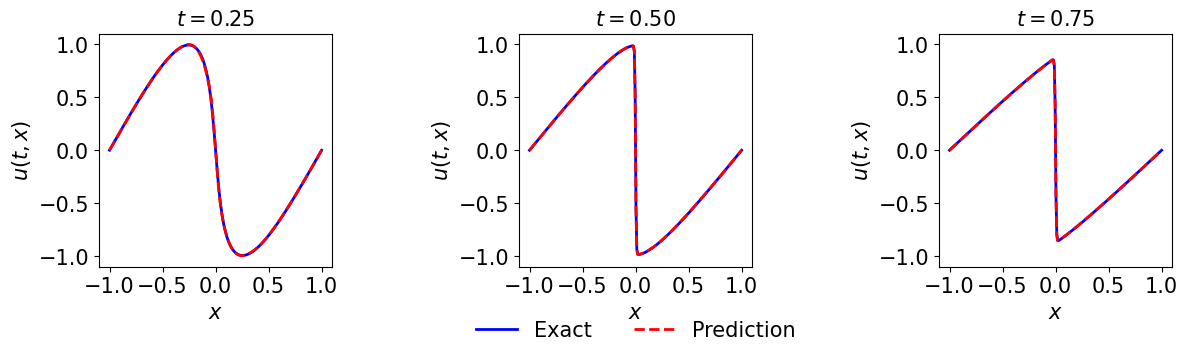

In [4]:
    # 1 u(t, x) slices

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)

    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])

    ax.plot(x, Exact[25, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, U_pred[25, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t, x)$')
    ax.set_title('$t = 0.25$', fontsize=15)
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t, x)$')
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_title('$t = 0.50$', fontsize=15)
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=5,
        frameon=False,
        prop={'size': 15}
    )

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x, Exact[75, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, U_pred[75, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t, x)$')
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_title('$t = 0.75$', fontsize=15)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

    plt.show()

